<a href="https://colab.research.google.com/github/tsakailab/iip/blob/main/colab/iip_cnn_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNの実装に挑戦！

物体認識のCNNモデルを設計し，画像を教師あり学習させます．

## 【モデル作り】モデルを定義します．

下記の例では，torch.nn を用いてモデルを作成しています．

- 入力はチャンネル数3のカラー画像，出力のチャネル数はクラスの数  num_classes で与えられるものとします．

- nn.Sequential()に各層を順に記述することで，特徴抽出部 features，抽出した特徴をベクトルに変換する avgpool，識別部 classifier を定義します．
    - [畳み込み層](https://pytorch.org/docs/stable/nn.html#convolution-layers)：[nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) 
    - [バッチノルム層](https://pytorch.org/docs/stable/nn.html#normalization-layers)：[nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
    - [活性化層](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)：[nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)，[nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)
    - [プーリング層](https://pytorch.org/docs/stable/nn.html#pooling-layers)：[nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)，[nn.AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html)，[nn.AdaptiveAvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html)
    - [全結合層](https://pytorch.org/docs/stable/nn.html#linear-layers)：[nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

- forward関数で順伝播記述します．

畳み込み層のチャンネル数（in_channels，out_channels）やカーネルのサイズ（kernel_size）などに調整の余地があるかもしれません．


<!--
        #x = x.mean([-2, -1]) # GAP
        # x = x.view(x.shape[0], -1) # flatten
-->

In [1]:
from torch import nn

class my_model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, 3, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=128, out_features=num_classes, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x).squeeze(-1).squeeze(-1) # [B, C, H=1, W=1] -> [B, C]
        x = self.classifier(x)
        return x

###定義どおりにモデルを生成できます．

my_modelで生成すると共に，to(device)でGPUに転送します．

In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nclasses = 2
model = my_model(nclasses).to(device)

from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]           2,432
       BatchNorm2d-2         [-1, 32, 126, 126]              64
              ReLU-3         [-1, 32, 126, 126]               0
         MaxPool2d-4           [-1, 32, 63, 63]               0
            Conv2d-5           [-1, 64, 63, 63]          18,496
       BatchNorm2d-6           [-1, 64, 63, 63]             128
              ReLU-7           [-1, 64, 63, 63]               0
         MaxPool2d-8           [-1, 64, 31, 31]               0
            Conv2d-9          [-1, 128, 31, 31]          73,856
      BatchNorm2d-10          [-1, 128, 31, 31]             256
             ReLU-11          [-1, 128, 31, 31]               0
        MaxPool2d-12          [-1, 128, 15, 15]               0
AdaptiveAvgPool2d-13            [-1, 128, 1, 1]               0
           Linear-14                   

## 【データの入手】教師あり学習に使う画像集合のzipファイルを指定します．
- zipURL: zipファイルの在処
- root_dir: zipを展開すると作られるディレクトリ名
- train_dir, val_dir: 画像集合はroot_dirの中で訓練用と検証用に分けられているものとします．それらのディレクトリ名です．各ディレクトリの下には，クラス名のディレクトリがあり，クラス毎に画像が分けられているものとします．

In [3]:
zipURL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
root_dir, train_dir, val_dir = "./hymenoptera_data", "train", "val"
#zipURL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
#root_dir, train_dir, val_dir = "./cats_and_dogs_filtered", "train", "validation"

In [4]:
#@title 画像集合をダウンロードします．

import zipfile
import os
!wget $zipURL --no-check-certificate --show-progress -q -O "./image_dataset.zip"
with zipfile.ZipFile("./image_dataset.zip", 'r') as f:
    f.extractall("./")

class_names = os.listdir(os.path.join(root_dir, train_dir))

from glob import glob
for name in class_names:
    print("train:", name, len(glob(os.path.join(root_dir, train_dir, name, "*"))), 'images')
for name in class_names:
    print("val:", name, len(glob(os.path.join(root_dir, val_dir, name, "*"))), 'images')

./image_dataset.zip 100%[===================>]  45.10M  55.7MB/s    in 0.8s    
train: bees 121 images
train: ants 124 images
val: bees 83 images
val: ants 70 images


## 【データを読み込む設定】モデルの入出力のため，DataLoaderを作成します．

hparamは，学習に関わる設定値で，予め与える必要がある[ハイパーパラメータ](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning))です．学習の結果や計算量が変わります．

data_transformsは，train_dirとval_dirにある訓練画像と検証画像の読み込み方を設定するためのdictionary（辞書）です．
- train_dirに収められた画像をモデルの学習に用います．
- val_dirにある画像は，訓練画像でない画像に対する識別の性能を観察するために用います．
- ImageNetの使用に倣って色を正規化します（'mean_color' と 'std_color'）．
- データ拡張もここで定義します．例：transforms.RandomHorizontalFlip()
- 訓練画像集合は，batch_size枚の**ミニバッチ（mini batch）**に小分けにして学習させます．

In [5]:
hparam = {'batch_size': 16, 'image_size': (224, 224),
          'shuffle': True, 'num_workers': 2,
          'mean_color': [0.485, 0.456, 0.406], 'std_color': [0.229, 0.224, 0.225]}

from torchvision import transforms
data_transforms = {
    train_dir:
        transforms.Compose([
        transforms.Resize(hparam['image_size']),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(hparam['mean_color'], hparam['std_color'])
    ]),
    val_dir:
        transforms.Compose([
        transforms.Resize(hparam['image_size']),
        transforms.ToTensor(),
        transforms.Normalize(hparam['mean_color'], hparam['std_color'])
    ]),
}

dataset sizes: {'train': 244, 'val': 153} , class_names: ['ants', 'bees']
Input batch of shape [B, C, H, W] = torch.Size([16, 3, 224, 224])


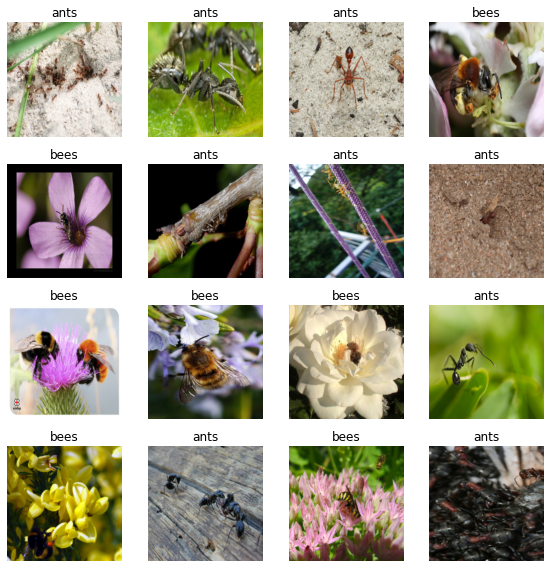

In [6]:
#@title DataLoader を作成し，訓練画像のミニバッチの例を表示します．
import torch
from torchvision import datasets
import os
image_datasets = {x: datasets.ImageFolder(os.path.join(root_dir, x), data_transforms[x])
                  for x in [train_dir, val_dir]}
dataset_sizes = {x: len(image_datasets[x]) for x in [train_dir, val_dir]}
class_names = image_datasets[train_dir].classes
print("dataset sizes:", dataset_sizes, ", class_names:", class_names)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=hparam['batch_size'],
                                              shuffle=hparam['shuffle'], num_workers=hparam['num_workers'])
               for x in [train_dir, val_dir]}


import numpy as np
import matplotlib.pyplot as plt
def plotImages(img_arr, lbl_arr, colors_arr=None, figsize=(8, 4),
               mean=np.array(hparam['mean_color']), std = np.array(hparam['std_color'])):

    if len(img_arr) <= min(figsize): rc = (1, len(img_arr))
    else: rc = (figsize[1], min(len(img_arr)//figsize[1], figsize[0]))
    fig, axes = plt.subplots(rc[0], rc[1], figsize=(rc[1]*2, rc[0]*2))
    axes = axes.flatten()
    if colors_arr is None: colors_arr = ['k']*len(lbl_arr)
    for img, lbl, c, ax in zip( img_arr, lbl_arr, colors_arr, axes):
        img = img.numpy().transpose((1,2,0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(lbl, color=c)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

inputs, labels = next(iter(dataloaders[train_dir]))
print("Input batch of shape [B, C, H, W] =", inputs.shape)
plotImages(inputs, [class_names[l] for l in labels])

## モデルを生成します

In [8]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nclasses = len(class_names)
model = my_model(nclasses).to(device)

from torchsummary import summary
summary(model, (3, hparam['image_size'][0], hparam['image_size'][1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]           2,432
       BatchNorm2d-2         [-1, 32, 222, 222]              64
              ReLU-3         [-1, 32, 222, 222]               0
         MaxPool2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 64, 111, 111]          18,496
       BatchNorm2d-6         [-1, 64, 111, 111]             128
              ReLU-7         [-1, 64, 111, 111]               0
         MaxPool2d-8           [-1, 64, 55, 55]               0
            Conv2d-9          [-1, 128, 55, 55]          73,856
      BatchNorm2d-10          [-1, 128, 55, 55]             256
             ReLU-11          [-1, 128, 55, 55]               0
        MaxPool2d-12          [-1, 128, 27, 27]               0
AdaptiveAvgPool2d-13            [-1, 128, 1, 1]               0
           Linear-14                   

## 【学習の設定】[損失関数](https://pytorch.org/docs/stable/nn.html#loss-functions)と[最適化のアルゴリズム](https://pytorch.org/docs/stable/optim.html)を指定します．

モデルの学習とは，入力画像から正しく識別結果を出力できるようにモデルの学習可能パラメータ（Trainable parameters）を調整することです．出力の正しさは損失関数（loss function）で評価します．損失ができるだけ小さな値になるように学習可能パラメータを調整する計算の方法が最適化のアルゴリズムです．

最適化のアルゴリズムでは，学習可能パラメータを少しずつ修正して，損失関数を徐々に小さくします．この修正を反復した結果，訓練画像すべてに対して損失関数が十分に小さくなるような学習可能パラメータ（畳み込み層のカーネルや全結合層の重み）が求まります．

訓練画像集合のミニバッチ毎に学習可能パラメータは修正されます．最適化において，すべての訓練画像が一巡する回数をエポック（epoch）といいます．収束に必要なエポック数は数～数百で，最適化問題とアルゴリズムに依存します．

- 識別の評価には交差エントロピー損失関数[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)を使います．モデルが識別結果を正しく出力できるほど，損失は小さいと評価します．
- 定番の最適化のアルゴリズムは[Adam](https://arxiv.org/abs/1412.6980)です．[optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)のオプション lr で学習率を設定します．
- 学習率とは，学習可能パラメータを修正する大きさの目安です．小さすぎると収束までに時間がかかります．大きすぎると損失関数が徐々に小さくならずに発散します．ハイパーパラメータ hparam['learning_rate']で指定します．
- エポック数もハイパーパラメータです．hparam['epochs']で指定します．

In [9]:
criterion = nn.CrossEntropyLoss()

from torch import optim
hparam['learning_rate'] = 0.001
optimizer_ft = optim.Adam(model.parameters(), lr=hparam['learning_rate'])

#hparam['momentum'] = 0.9
#optimizer_ft = optim.SGD(model.parameters(), lr=hparam['learning_rate'], momentum=hparam['momentum'])

hparam['epochs'] = 20

In [10]:
#@title 学習を実行する関数 run_training を定義します．
import time
import copy
 ## Define some function(training, printing result)
def run_training(model, criterion, optimizer, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {train_dir: [], val_dir: []}
    acc_dict = {train_dir: [], val_dir: []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [train_dir, val_dir]:
            if phase == train_dir:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_dir):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train_dir:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc)

            print('{} loss: {:.4f},  acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == val_dir and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_dict, acc_dict


## 【学習の実行】モデルを最適化します．

注意：とても時間がかかることがあります．この例では数分～数十分が目安です．停止ボタンで停止したときは，モデルの生成（※）のセルから実行し直してください．

- train loss が徐々に減少し，acc（0<=acc<=1）が上昇傾向ですか．

In [ ]:
model_ft, loss_dict, acc_dict = run_training(model, criterion, optimizer_ft, num_epochs=hparam['epochs'])

Epoch 0/19
----------
train loss: 0.7233,  acc: 0.5738
val loss: 0.6823,  acc: 0.6144

Epoch 1/19
----------
train loss: 0.5967,  acc: 0.6885
val loss: 0.6485,  acc: 0.6405

Epoch 2/19
----------
train loss: 0.5914,  acc: 0.6721
val loss: 0.7684,  acc: 0.5817

Epoch 3/19
----------
train loss: 0.6156,  acc: 0.6557
val loss: 0.5918,  acc: 0.6863

Epoch 4/19
----------
train loss: 0.5696,  acc: 0.7377
val loss: 0.5770,  acc: 0.6993

Epoch 5/19
----------
train loss: 0.5776,  acc: 0.6844
val loss: 0.5827,  acc: 0.7059

Epoch 6/19
----------
train loss: 0.5347,  acc: 0.6844
val loss: 0.6597,  acc: 0.6536

Epoch 7/19
----------
train loss: 0.5752,  acc: 0.6844
val loss: 0.5176,  acc: 0.7255

Epoch 8/19
----------
train loss: 0.5868,  acc: 0.7172
val loss: 0.5401,  acc: 0.7320

Epoch 9/19
----------
train loss: 0.5361,  acc: 0.6844
val loss: 0.5632,  acc: 0.7320

Epoch 10/19
----------
train loss: 0.5546,  acc: 0.7131
val loss: 0.6608,  acc: 0.6536

Epoch 11/19
----------
train loss: 0.5507,

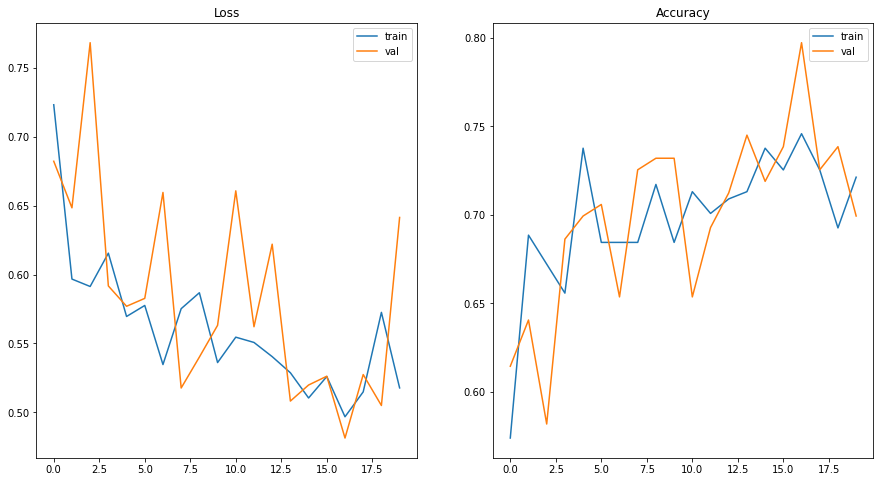

In [ ]:
#@title 学習の過程における損失関数と正答率の変化を表示します．
def plotting_history(loss_dict, acc_dict):
    epoch = len(loss_dict[train_dir])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
    axes[0].plot(range(epoch), loss_dict[train_dir], label=train_dir)
    axes[0].plot(range(epoch), loss_dict[val_dir], label=val_dir)
    axes[0].set_title("Loss")
    axes[0].legend()

    axes[1].plot(range(epoch), acc_dict[train_dir], label=train_dir)
    axes[1].plot(range(epoch), acc_dict[val_dir], label=val_dir)
    axes[1].set_title("Accuracy")
    axes[1].legend()

plotting_history(loss_dict, acc_dict)

(ground truth, prediction)


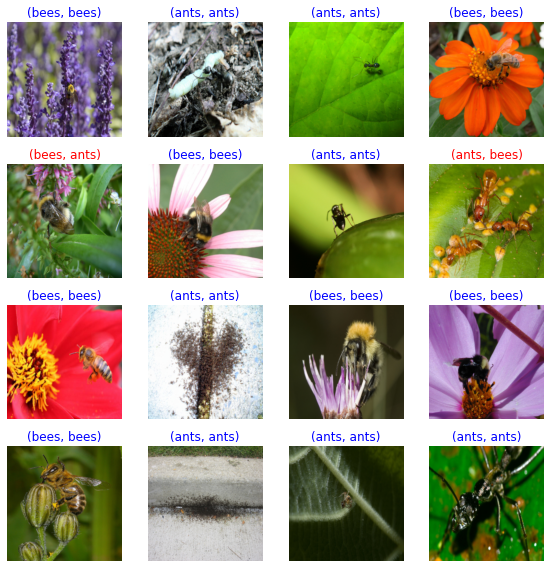

In [ ]:
#@title 検証用の画像に対する結果を例示します（このセルを実行する度に例が変わります）．
inputs, labels = next(iter(dataloaders[val_dir]))
model.eval()
with torch.no_grad():
    outputs = model(inputs.to(device))

probabilities = nn.functional.softmax(outputs, dim=1)
_, preds = torch.max(probabilities, dim=1)

lbl_preds = [class_names[l] for l in preds]
lbl_gts = [class_names[l] for l in labels]
colors_arr = ['blue' if g== p else 'red' for g, p in zip(lbl_gts, lbl_preds)]

print("(ground truth, prediction)")
plotImages(inputs, ["(" + g + ", " + p + ")" for g, p in zip(lbl_gts, lbl_preds)], colors_arr=colors_arr)